### Preprocessing

In [74]:
import json
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from nltk import bigrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/cyprienfourcroy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cyprienfourcroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download("wordnet")    
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cyprienfourcroy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/cyprienfourcroy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
with open("datasets/putin_complete.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print("HEAD (raw):")
print(df.head(2))
print("\nNumber of rows:", len(df))
print("Columns:", df.columns.tolist())

text_cols = ["transcript_unfiltered", "transcript_filtered"]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()].reset_index(drop=True)

putin_mask = df["transcript_unfiltered"].str.contains(r"\bPutin\b\s*:", regex=True, na=False)
df = df[putin_mask].reset_index(drop=True)

df["transcript_unfiltered"] = df["transcript_unfiltered"].str.replace(
    r"^.*\bPutin\b\s*:\s*", "", regex=True
)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df["text_raw"] = df["transcript_filtered"].where(
    df["transcript_filtered"].str.len() > 0,
    df["transcript_unfiltered"]
)

df["sentences"] = df["text_raw"].apply(
    lambda x: re.split(r"(?<=[.!?])\s+", x.strip()) if x.strip() else []
)

df["sentence_count"] = df["sentences"].apply(len)

def ensure_wordlist(row):
    wl = row.get("wordlist", None)
    if not isinstance(wl, list) or len(wl) == 0:
        return word_tokenize(row["text_raw"])
    return wl

df["tokens_full"] = df.apply(ensure_wordlist, axis=1)

def clean_tokens(tokens):
    return [t.lower() for t in tokens if t.strip() != ""]

df["tokens_clean"] = df["tokens_full"].apply(clean_tokens)

def keep_alpha_tokens(tokens):
    return [t for t in tokens if re.fullmatch(r"[a-z]+", t)]

df["tokens_lexical"] = df["tokens_clean"].apply(keep_alpha_tokens)

stop_words = set(stopwords.words("english"))

df["tokens_nostop"] = df["tokens_lexical"].apply(
    lambda x: [t for t in x if t not in stop_words]
)

lemmatizer = WordNetLemmatizer()

df["tokens_lemma"] = df["tokens_nostop"].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)

df["token_count"] = df["tokens_lexical"].apply(len)
df["unique_tokens"] = df["tokens_lexical"].apply(lambda x: len(set(x)))

df["lexical_diversity"] = df.apply(
    lambda r: r["unique_tokens"] / r["token_count"] if r["token_count"] > 0 else 0,
    axis=1
)

df["avg_sentence_length"] = df.apply(
    lambda r: r["token_count"] / r["sentence_count"] if r["sentence_count"] > 0 else 0,
    axis=1
)

def rhetorical_features(text):
    return {
        "exclamation_count": text.count("!"),
        "question_count": text.count("?"),
        "ellipsis_count": text.count("...")
    }

rhet_feats = df["text_raw"].apply(rhetorical_features)
rhet_df = pd.DataFrame(list(rhet_feats))
df = pd.concat([df, rhet_df], axis=1)

HEAD (raw):
                  date persons  \
0  1999-12-31T00:01:00      []   
1  1999-12-31T00:02:00      []   

                               transcript_unfiltered  kremlin_id  \
0  Vladimir Putin: Dear friends, On New Year’s Ev...     22280.0   
1  Vladimir Putin: Good afternoon, distinguished ...     22326.0   

                 place                                              title  \
0  The Kremlin, Moscow  New Year Address by Acting President Vladimir ...   
1  The Kremlin, Moscow  Address at an expanded meeting of the Russian ...   

  teaser tags                                transcript_filtered  \
0          []  Dear friends, On New Year’s Eve, my family and...   
1          []  Good afternoon, distinguished colleagues. This...   

                                            wordlist  
0  [dear, friend, ,, on, New, Year, ’s, Eve, ,, m...  
1  [good, afternoon, ,, distinguished, colleague,...  

Number of rows: 9838
Columns: ['date', 'persons', 'transcript_unfiltered', 'k

In [9]:
df.to_json(
    "datasets/putin_complete_cleaned.json",
    orient="records",
    force_ascii=False,
    indent=2
)

print("\nSaved cleaned dataset: putin_complete_cleaned.json")


Saved cleaned dataset: putin_complete_cleaned.json


In [126]:
with open("datasets/putin_complete_cleaned.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [127]:
df.columns

Index(['date', 'persons', 'transcript_unfiltered', 'kremlin_id', 'place',
       'title', 'teaser', 'tags', 'transcript_filtered', 'wordlist', 'year',
       'month', 'text_raw', 'sentences', 'sentence_count', 'tokens_full',
       'tokens_clean', 'tokens_lexical', 'tokens_nostop', 'tokens_lemma',
       'token_count', 'unique_tokens', 'lexical_diversity',
       'avg_sentence_length', 'exclamation_count', 'question_count',
       'ellipsis_count'],
      dtype='object')

In [128]:
df

,date,persons,transcript_unfiltered,kremlin_id,place,title,teaser,tags,transcript_filtered,wordlist,...,tokens_lexical,tokens_nostop,tokens_lemma,token_count,unique_tokens,lexical_diversity,avg_sentence_length,exclamation_count,question_count,ellipsis_count
0,946598460000,[],"Dear friends, On New Year’s Eve, my family and...",22280.0,"The Kremlin, Moscow",New Year Address by Acting President Vladimir ...,,[],"Dear friends, On New Year’s Eve, my family and...","[dear, friend, ,, on, New, Year, ’s, Eve, ,, m...",...,"[dear, friend, on, new, year, eve, my, family,...","[dear, friend, new, year, eve, family, plan, g...","[dear, friend, new, year, eve, family, plan, g...",356,174,0.488764,16.181818,1,0,0
1,946598520000,[],"Good afternoon, distinguished colleagues. This...",22326.0,"The Kremlin, Moscow",Address at an expanded meeting of the Russian ...,,[],"Good afternoon, distinguished colleagues. This...","[good, afternoon, ,, distinguished, colleague,...",...,"[good, afternoon, distinguished, colleague, th...","[good, afternoon, distinguished, colleague, sh...","[good, afternoon, distinguished, colleague, sh...",732,287,0.392077,19.263158,0,0,0
2,946944000000,[],Thank you. Happy New Year!,24377.0,Moscow,Interview with the ORT TV Channel,,[],Let’s try. It was about ten days before the Ne...,"[let, ’s, try, ., , it, be, about, ten, day, ...",...,"[let, try, it, be, about, ten, day, before, th...","[let, try, ten, day, new, year, come, routine,...","[let, try, ten, day, new, year, come, routine,...",2090,519,0.248325,13.227848,1,3,0
3,947548800000,[],"Dear friends, We are again gathered here today...",24116.0,"State Kremlin Palace, Moscow",Speech at gala function marking the second mil...,,[],"Dear friends, We are again gathered here today...","[dear, friend, ,, we, be, again, gather, here,...",...,"[dear, friend, we, be, again, gather, here, to...","[dear, friend, gather, today, time, occasion, ...","[dear, friend, gather, today, time, occasion, ...",695,301,0.433094,23.166667,2,0,0
4,947894400000,[],"First, under the Constitution this decision is...",24123.0,,Interview with ORT Channel,,[],"No, they aren’t. The amount of work is about t...","[no, ,, they, be, n’t, ., , the, amount, of, ...",...,"[no, they, be, the, amount, of, work, be, abou...","[amount, work, responsibility, course, nothing...","[amount, work, responsibility, course, nothing...",2537,670,0.264091,13.788043,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7624,1706208300000,[],"Next, one focus should be making full use of t...",NaN,Kaliningrad,Meeting on the socioeconomic development of th...,Taking part in the meeting were deputy prime m...,[],,[],...,"[next, one, focus, should, be, making, full, u...","[next, one, focus, making, full, use, region, ...","[next, one, focus, making, full, use, region, ...",569,291,0.511424,23.708333,0,0,1
7625,1706287800000,[],"Good afternoon, friends. Today is a major, gra...",NaN,St Petersburg,Keel-laying ceremony for the nuclear-powered i...,The ship will be built as part of the Developm...,[],,[],...,"[good, afternoon, friends, today, is, a, major...","[good, afternoon, friends, today, major, grati...","[good, afternoon, friend, today, major, gratif...",452,254,0.561947,23.789474,0,0,1
7626,1706297400000,[],"First, in our country, a decision to declare a...",NaN,St Petersburg,Meeting with students that participated in the...,"Prior to the meeting, the President toured the...",[],,[],...,"[first, in, our, country, a, decision, to, dec...","[first, country, decision, declare, anyone, te...","[first, country, decision, declare, anyone, te...",592,276,0.466216,15.179487,0,0,0
7627,1706302800000,[],"Good afternoon, colleagues! The Governor and I...",NaN,St Petersburg,Meeting on socioeconomic development of St Pet...,The meeting was attended by Deputy Prime Minis...,[],,[],...,"[good, afternoon, colleagues, the, governor, a...","[good, afternoon, colleagues, governor, tried,...","[good, a

In [120]:

df_sent = df.explode("sentences").rename(columns={"sentences": "sentence"})
df_sent = df_sent[df_sent["sentence"].notna()].copy()
df_sent["sentence"] = df_sent["sentence"].astype(str).str.strip()
df_sent = df_sent[df_sent["sentence"] != ""].reset_index(drop=True)

In [121]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "./sentiment_roberta_large"

tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
model.eval()
print("Loaded labels:", model.config.id2label)


def batched_sentiment(
    texts,
    tokenizer,
    model,
    batch_size=16,
    max_length=256,
    desc="Sentiment",
    device=None
):
    """
    Returns:
      pos_probs: np.ndarray shape (N,)
      labels:    np.ndarray shape (N,)
    """
    # Resolve device
    if device is None:
        device = next(model.parameters()).device  # works even if model is on mps/cuda/cpu

    # Resolve POSITIVE index robustly
    id2label = model.config.id2label
    # Normalize labels to uppercase strings
    label_map = {int(k): str(v).upper() for k, v in id2label.items()}
    pos_candidates = [k for k, v in label_map.items() if v == "POSITIVE"]

    if not pos_candidates:
        raise ValueError(
            f"Could not find a POSITIVE label in model.config.id2label: {model.config.id2label}"
        )
    pos_index = pos_candidates[0]

    all_pos_probs = np.empty(len(texts), dtype=np.float32)
    all_labels = np.empty(len(texts), dtype=np.int64)

    # Iterate in batches with tqdm
    for start in tqdm(range(0, len(texts), batch_size), desc=desc):
        batch = texts[start:start + batch_size]

        enc = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )

        # Move inputs to same device as model
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1)

        # Move results to CPU numpy
        probs_cpu = probs.detach().cpu().numpy()
        labels_cpu = probs.argmax(dim=-1).detach().cpu().numpy()

        end = start + len(batch)
        all_pos_probs[start:end] = probs_cpu[:, pos_index]
        all_labels[start:end] = labels_cpu

    return all_pos_probs, all_labels

import torch

text = "Germany is acting irresponsibly, while Poland remains pragmatic."

enc = tokenizer(text, return_tensors="pt", truncation=True)
with torch.no_grad():
    logits = model(**enc).logits
probs = torch.softmax(logits, dim=-1)[0].tolist()

print("probs:", probs)
print("pred:", model.config.id2label[int(torch.argmax(logits))])




Loaded labels: {0: 'NEGATIVE', 1: 'POSITIVE'}
probs: [0.9968913197517395, 0.00310869375243783]
pred: NEGATIVE


### Comparaison

### 1. How does the narrative toward Poland differ from that toward Germany? (Sentiment analysis, RoBERTa)
 

We are going to use sentiment_roberta_large_english which has a legacy format from HuggingFace

Run the following commands to download the model 

In [ ]:
# # Model weights (large ~1.3–1.4GB)
# curl -L --fail --retry 10 --retry-delay 2 -C - \
#   -o pytorch_model.bin \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/pytorch_model.bin"

# # Model config
# curl -L --fail --retry 10 --retry-delay 2 \
#   -o config.json \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json"

# # Tokenizer files (RoBERTa BPE)
# curl -L --fail --retry 10 --retry-delay 2 \
#   -o vocab.json \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/vocab.json"

# curl -L --fail --retry 10 --retry-delay 2 \
#   -o merges.txt \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt"

# # Tokenizer metadata
# curl -L --fail --retry 10 --retry-delay 2 \
#   -o tokenizer_config.json \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/tokenizer_config.json"

# curl -L --fail --retry 10 --retry-delay 2 \
#   -o special_tokens_map.json \
#   "https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/special_tokens_map.json"



In [125]:






pl_sent = df_sent[df_sent["sentence"].str.contains(r"\bPoland\b", case=False, na=False)].copy()
de_sent = df_sent[df_sent["sentence"].str.contains(r"\bGermany\b", case=False, na=False)].copy()

print("Poland sentences:", len(pl_sent))
print("Germany sentences:", len(de_sent))


Poland sentences: 363
Germany sentences: 1485


In [16]:
pl_texts = pl_sent["sentence"].tolist()
de_texts = de_sent["sentence"].tolist()

pl_pos_probs, pl_labels = batched_sentiment(pl_texts, tokenizer, model, batch_size=16)
de_pos_probs, de_labels = batched_sentiment(de_texts, tokenizer, model, batch_size=16)

pl_sent["pos_prob"] = pl_pos_probs
pl_sent["label"] = pl_labels

de_sent["pos_prob"] = de_pos_probs
de_sent["label"] = de_labels


In [17]:
def sentiment_proportions(df_local):
    total = len(df_local)
    pos = (df_local["label"] == 1).sum()
    neg = (df_local["label"] == 0).sum()
    return {
        "positive": pos / total if total > 0 else 0,
        "negative": neg / total if total > 0 else 0,
        "count": total
    }

pl_props = sentiment_proportions(pl_sent)
de_props = sentiment_proportions(de_sent)

print("Poland sentiment distribution:", pl_props)
print("Germany sentiment distribution:", de_props)


Poland sentiment distribution: {'positive': np.float64(0.6318681318681318), 'negative': np.float64(0.36813186813186816), 'count': 364}
Germany sentiment distribution: {'positive': np.float64(0.8055181695827726), 'negative': np.float64(0.19448183041722747), 'count': 1486}


In [18]:
import matplotlib.pyplot as plt
import numpy as np


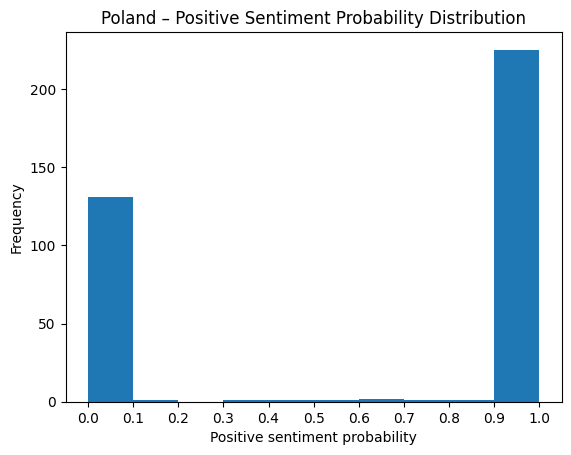

In [20]:
bins = np.arange(0, 1.1, 0.1)

plt.figure()
plt.hist(pl_sent["pos_prob"], bins=bins)
plt.title("Poland – Positive Sentiment Probability Distribution")
plt.xlabel("Positive sentiment probability")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.show()



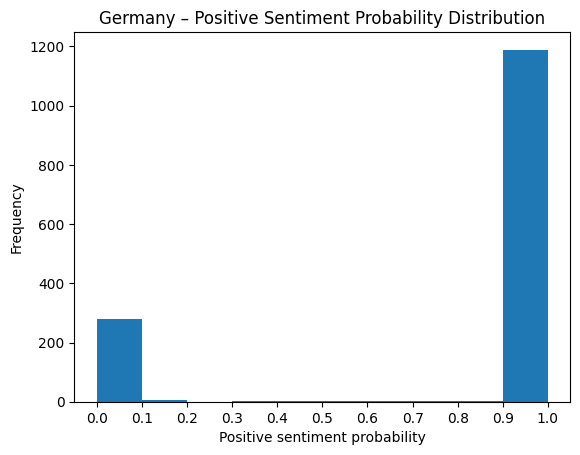

In [21]:
plt.figure()
plt.hist(de_sent["pos_prob"], bins=bins)
plt.title("Germany – Positive Sentiment Probability Distribution")
plt.xlabel("Positive sentiment probability")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.show()


### 2. Does he speak more positively about China than about India? (Sentiment analysis, RoBERTa) 

In [97]:



pattern_china = r"\bChina\b"
pattern_india = r"\bIndia\b"

china_sent = df_sent[df_sent["sentence"].str.contains(pattern_china, case=False, na=False)].copy()
india_sent = df_sent[df_sent["sentence"].str.contains(pattern_india, case=False, na=False)].copy()

print("China sentences:", len(china_sent))
print("India sentences:", len(india_sent))

China sentences: 2559
India sentences: 1071


China sentences: 2559
India sentences: 1071
China sentiment distribution: {'count': 2559, 'positive': 0.9015240328253223, 'negative': 0.0984759671746776}
India sentiment distribution: {'count': 1071, 'positive': 0.9393090569561158, 'negative': 0.06069094304388422}
Δ positive rate (China - India): -0.038


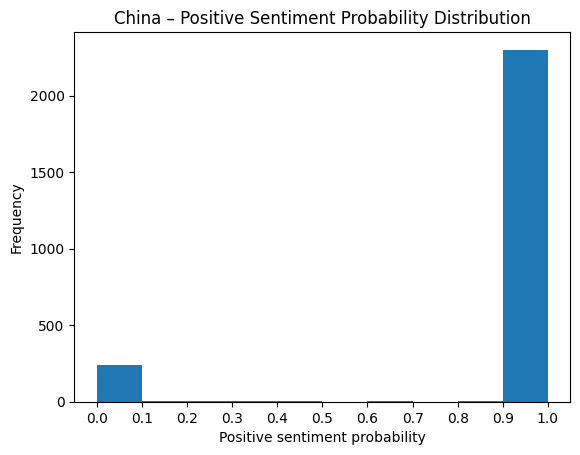

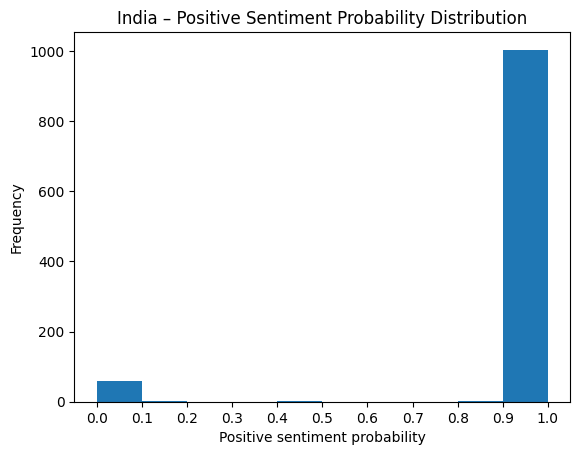

In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import numpy as np
import torch
from tqdm.auto import tqdm



def sentiment_proportions(df_local):
    total = len(df_local)
    pos = int((df_local["label"] == 1).sum())
    neg = int((df_local["label"] == 0).sum())
    return {
        "count": total,
        "positive": pos / total if total else 0.0,
        "negative": neg / total if total else 0.0,
    }


def plot_posprob_hist(pos_probs, title):
    bins = np.arange(0.0, 1.0 + 0.1, 0.1)
    plt.figure()
    plt.hist(pos_probs, bins=bins)
    plt.title(title)
    plt.xlabel("Positive sentiment probability")
    plt.ylabel("Frequency")
    plt.xticks(bins)
    plt.show()




a


china_texts = china_sent["sentence"].tolist()
india_texts = india_sent["sentence"].tolist()

china_pos_probs, china_labels = batched_sentiment(china_texts, tokenizer, model, batch_size=16)
india_pos_probs, india_labels = batched_sentiment(india_texts, tokenizer, model, batch_size=16)

china_sent["pos_prob"] = china_pos_probs
china_sent["label"] = china_labels

india_sent["pos_prob"] = india_pos_probs
india_sent["label"] = india_labels

china_props = sentiment_proportions(china_sent)
india_props = sentiment_proportions(india_sent)

print("China sentiment distribution:", china_props)
print("India sentiment distribution:", india_props)


if china_props["count"] > 0 and india_props["count"] > 0:
    diff = china_props["positive"] - india_props["positive"]
    print(f"Δ positive rate (China - India): {diff:+.3f}")

plot_posprob_hist(china_sent["pos_prob"].values, "China – Positive Sentiment Probability Distribution")
plot_posprob_hist(india_sent["pos_prob"].values, "India – Positive Sentiment Probability Distribution")


### 3. How does the tone toward the USA compare with that toward the European Union? (Sentiment analysis + topic modeling, RoBERTa / BERTopic)


In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




usa_pattern = r"\b(USA|U\.S\.A\.|U\.S\.|US|United States)\b"
eu_pattern  = r"\b(EU|European Union)\b"

usa_sent = df_sent[df_sent["sentence"].str.contains(usa_pattern, case=False, na=False, regex=True)].copy()
eu_sent  = df_sent[df_sent["sentence"].str.contains(eu_pattern,  case=False, na=False, regex=True)].copy()

print("USA sentences:", len(usa_sent))
print("EU sentences:", len(eu_sent))

USA sentences: 16627
EU sentences: 2002


In [17]:
usa_texts = usa_sent["sentence"].astype(str).tolist()
eu_texts  = eu_sent["sentence"].astype(str).tolist()

usa_pos_prob, usa_label = batched_sentiment(
    usa_texts, tokenizer, model,
    batch_size=16, max_length=256,
    desc="Sentiment (USA)"
)

eu_pos_prob, eu_label = batched_sentiment(
    eu_texts, tokenizer, model,
    batch_size=16, max_length=256,
    desc="Sentiment (EU)"
)

usa_sent["pos_prob"] = usa_pos_prob
usa_sent["label"] = usa_label

eu_sent["pos_prob"] = eu_pos_prob
eu_sent["label"] = eu_label


Sentiment (USA):   0%|          | 0/1040 [00:00<?, ?it/s]

Sentiment (EU):   0%|          | 0/126 [00:00<?, ?it/s]

We aim to determine in which thematic contexts Putin’s discourse toward the USA and the EU is framed positively or negatively. 

By applying BERTopic to identify narrative themes and combining this with RoBERTa-based sentiment analysis, we can measure tone conditional on topic. 

For example, discourse related to economic cooperation or joint counter-terrorism efforts (e.g., in Syria) is expected to exhibit more positive framing, whereas discourse related to Ukraine is hypothesized to be predominantly negative

Formally :

Sentiment( USA | Counter-terrorisme ) > Sentiment ( USA |  War in Ukraine )

In [2]:
import os

os.makedirs("dataset", exist_ok=True)

usa_path = "datasets/usa_sentiment.parquet"
eu_path  = "datasets/eu_sentiment.parquet"

usa_sent.to_parquet(usa_path, index=False)
eu_sent.to_parquet(eu_path, index=False)

print(f"[SAVE] USA sentiment saved to {usa_path} ({len(usa_sent)} rows)")
print(f"[SAVE] EU  sentiment saved to {eu_path} ({len(eu_sent)} rows)")


NameError: name 'usa_sent' is not defined

In [115]:
import pandas as pd

usa_sent = pd.read_parquet("datasets/usa_sentiment.parquet")
eu_sent  = pd.read_parquet("datasets/eu_sentiment.parquet")

print("[LOAD] USA sentiment:", usa_sent.shape)
print("[LOAD] EU  sentiment:", eu_sent.shape)


[LOAD] USA sentiment: (16627, 30)
[LOAD] EU  sentiment: (2002, 30)


In [27]:
def sentiment_summary(df_local):
    total = len(df_local)
    pos = int((df_local["label"] == 1).sum())
    neg = int((df_local["label"] == 0).sum())
    return {
        "count": total,
        "positive_rate": pos / total if total else 0.0,
        "negative_rate": neg / total if total else 0.0,
        "mean_pos_prob": float(df_local["pos_prob"].mean()) if total else 0.0
    }

usa_stats = sentiment_summary(usa_sent)
eu_stats  = sentiment_summary(eu_sent)

print("USA sentiment:", usa_stats)
print("EU sentiment:", eu_stats)
print(f"Δ mean P(positive) (USA - EU): {usa_stats['mean_pos_prob'] - eu_stats['mean_pos_prob']:+.3f}")


USA sentiment: {'count': 16627, 'positive_rate': 0.734889035905455, 'negative_rate': 0.26511096409454504, 'mean_pos_prob': 0.7341265678405762}
EU sentiment: {'count': 2002, 'positive_rate': 0.7652347652347652, 'negative_rate': 0.23476523476523475, 'mean_pos_prob': 0.7638316750526428}
Δ mean P(positive) (USA - EU): -0.030


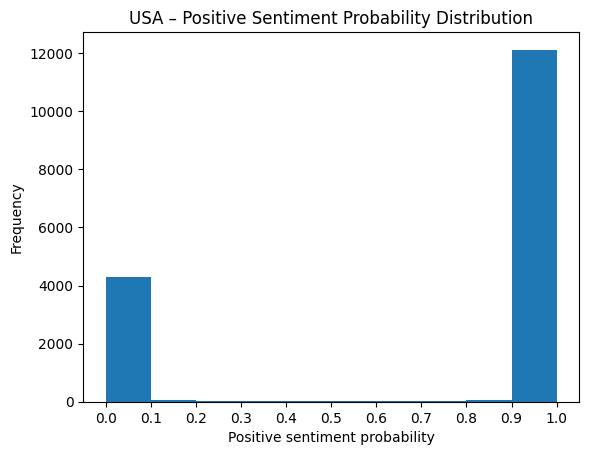

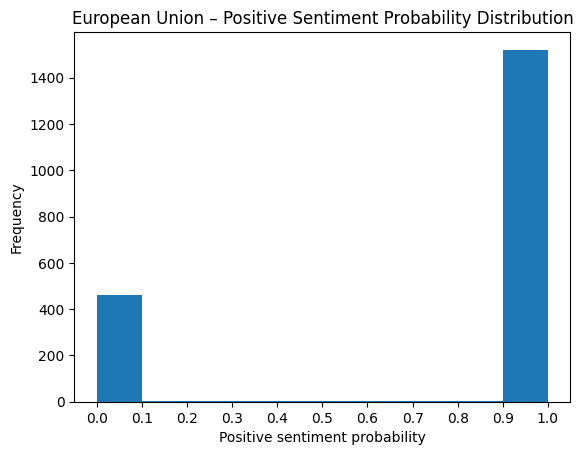

In [28]:
bins = np.arange(0.0, 1.0 + 0.1, 0.1)

plt.figure()
plt.hist(usa_sent["pos_prob"], bins=bins)
plt.title("USA – Positive Sentiment Probability Distribution")
plt.xlabel("Positive sentiment probability")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.show()

plt.figure()
plt.hist(eu_sent["pos_prob"], bins=bins)
plt.title("European Union – Positive Sentiment Probability Distribution")
plt.xlabel("Positive sentiment probability")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.show()


### add the all-mpnet-base-v2/ folder, download from Github https://github.com/homer6/all-mpnet-base-v2 with the bin file also
###  ( pytorch_model.bin )

In [4]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer


EMBEDDER_DIR = "./all-mpnet-base-v2"
embedder = SentenceTransformer(EMBEDDER_DIR)

from bertopic import BERTopic  

def fit_topics(texts, min_topic_size=20, name=""):
    print(f"\n[BERTOPIC] {name} | N={len(texts)}")
    model = BERTopic(embedding_model=embedder, min_topic_size=min_topic_size, verbose=True)
    topics, _ = model.fit_transform(texts)
    print(f"[BERTOPIC] done | topics={len(set(topics)) - (-1 in topics)} | outliers={int((np.array(topics)==-1).sum())}")
    return model, topics

def topic_tone_table(df, topic_model, top_n=10):
    
    freq = df[df.topic != -1]["topic"].value_counts().head(top_n).reset_index()
    freq.columns = ["topic", "count"]
    freq["keywords"] = freq["topic"].apply(lambda t: ", ".join(w for w, _ in (topic_model.get_topic(int(t)) or [])[:10]))
    tone = (df[df.topic != -1]
            .groupby("topic")
            .agg(mean_pos_prob=("pos_prob", "mean"),
                 positive_rate=("label", lambda x: float((x == 1).mean())))
            .reset_index())
    return freq.merge(tone, on="topic", how="left").sort_values("count", ascending=False)


usa_model, usa_topics = fit_topics(usa_sent["sentence"].astype(str).tolist(), min_topic_size=10, name="USA sentences")
usa_sent["topic"] = usa_topics


eu_model, eu_topics = fit_topics(eu_sent["sentence"].astype(str).tolist(), min_topic_size=10, name="EU sentences")
eu_sent["topic"] = eu_topics


usa_summary = topic_tone_table(usa_sent, usa_model, top_n=10)
eu_summary  = topic_tone_table(eu_sent,  eu_model,  top_n=10)

print("\nUSA topic-tone summary:\n", usa_summary.head(10))
print("\nEU topic-tone summary:\n", eu_summary.head(10))


2026-01-13 19:16:31,663 - BERTopic - Embedding - Transforming documents to embeddings.



[BERTOPIC] USA sentences | N=16627


Batches:   0%|          | 0/520 [00:00<?, ?it/s]

2026-01-13 19:17:27,092 - BERTopic - Embedding - Completed ✓
2026-01-13 19:17:27,093 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 19:17:35,527 - BERTopic - Dimensionality - Completed ✓
2026-01-13 19:17:35,528 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 19:17:36,994 - BERTopic - Cluster - Completed ✓
2026-01-13 19:17:36,999 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 19:17:37,147 - BERTopic - Representation - Completed ✓
2026-01-13 19:17:37,290 - BERTopic - Embedding - Transforming documents to embeddings.


[BERTOPIC] done | topics=185 | outliers=8013

[BERTOPIC] EU sentences | N=2002


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2026-01-13 19:17:44,593 - BERTopic - Embedding - Completed ✓
2026-01-13 19:17:44,593 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 19:17:48,910 - BERTopic - Dimensionality - Completed ✓
2026-01-13 19:17:48,910 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 19:17:48,934 - BERTopic - Cluster - Completed ✓
2026-01-13 19:17:48,936 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 19:17:48,957 - BERTopic - Representation - Completed ✓


[BERTOPIC] done | topics=23 | outliers=414

USA topic-tone summary:
    topic  count                                           keywords  \
0      0    436  russia, relations, united, states, between, ru...   
1      1    307  victory, memory, war, their, who, great, veter...   
2      2    283  infrastructure, development, technology, econo...   
3      3    220  ukraine, ukrainian, kiev, european, nato, they...   
4      4    215  sports, olympic, sport, games, athletes, olymp...   
5      5    205  meetings, discuss, meeting, issues, opportunit...   
6      6    204  partners, with, united, states, we, relations,...   
7      7    187  cooperation, relations, ties, develop, bilater...   
8      8    166  tasks, ahead, work, before, challenges, still,...   
9      9    161  unites, unite, values, things, common, differe...   

   mean_pos_prob  positive_rate  
0       0.626584       0.628440  
1       0.956047       0.957655  
2       0.963061       0.964664  
3       0.465334       0

In [5]:
usa_summary = topic_tone_table(usa_sent, usa_model)
eu_summary  = topic_tone_table(eu_sent,  eu_model)



In [6]:
usa_summary

,topic,count,keywords,mean_pos_prob,positive_rate
0,0,436,"russia, relations, united, states, between, ru...",0.626584,0.628440
1,1,307,"victory, memory, war, their, who, great, veter...",0.956047,0.957655
2,2,283,"infrastructure, development, technology, econo...",0.963061,0.964664
3,3,220,"ukraine, ukrainian, kiev, european, nato, they...",0.465334,0.463636
4,4,215,"sports, olympic, sport, games, athletes, olymp...",0.960495,0.962791
5,5,205,"meetings, discuss, meeting, issues, opportunit...",0.974191,0.975610
6,6,204,"partners, with, united, states, we, relations,...",0.953544,0.955882
7,7,187,"cooperation, relations, ties, develop, bilater...",0.993186,0.994652
8,8,166,"tasks, ahead, work, before, challenges, still,...",0.890243,0.891566
9,9,161,"unites, unite, values, things, common, differe...",0.961125,0.962733


In [7]:
eu_summary

,topic,count,keywords,mean_pos_prob,positive_rate
0,0,870,"russia, and, the, of, in, to, between, eu, eur...",0.838237,0.840230
1,1,115,"energy, gas, the, to, in, of, european, that, ...",0.746338,0.747826
2,2,95,"trade, is, billion, our, percent, countries, t...",0.696942,0.694737
3,3,78,"with, we, our, european, union, the, cooperati...",0.998350,1.000000
4,4,72,"ukraine, association, agreement, to, with, the...",0.450355,0.458333
5,5,36,"goods, customs, regulations, technical, ukrain...",0.310491,0.305556
6,6,35,"italy, italian, relations, between, of, the, r...",0.997968,1.000000
7,7,28,"subsidies, meat, products, agricultural, from,...",0.287957,0.285714
8,8,26,"kaliningrad, region, of, the, problems, transi...",0.883425,0.884615
9,9,26,"thank, of, mr, heads, the, luxembourg, preside...",0.959569,0.961538


In [8]:
def order_by_positivity(df_summary):
    return df_summary.sort_values("mean_pos_prob", ascending=False).reset_index(drop=True)

usa_ordered = order_by_positivity(usa_summary)
eu_ordered  = order_by_positivity(eu_summary)

print("\n=== USA topics ordered by positivity ===")
print(usa_ordered[["topic", "mean_pos_prob", "positive_rate", "count", "keywords"]].to_string(index=False))

print("\n=== EU topics ordered by positivity ===")
print(eu_ordered[["topic", "mean_pos_prob", "positive_rate", "count", "keywords"]].to_string(index=False))



=== USA topics ordered by positivity ===
 topic  mean_pos_prob  positive_rate  count                                                                                        keywords
     7       0.993186       0.994652    187         cooperation, relations, ties, develop, bilateral, our, help, partnership, will, further
     5       0.974191       0.975610    205      meetings, discuss, meeting, issues, opportunity, bilateral, informal, chance, useful, meet
     2       0.963061       0.964664    283 infrastructure, development, technology, economy, new, growth, projects, will, social, economic
     9       0.961125       0.962733    161               unites, unite, values, things, common, different, together, culture, makes, unity
     4       0.960495       0.962791    215              sports, olympic, sport, games, athletes, olympics, cup, sochi, football, committee
     1       0.956047       0.957655    307                   victory, memory, war, their, who, great, veterans, patri

In [ ]:
import re
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

def clean_keywords_string(s):
    """
    Input:  "with, the, european, union, cooperation, will"
    Output: "european, union, cooperation"
    """
    if not isinstance(s, str):
        return s

    parts = [w.strip().lower() for w in s.split(",")]

    cleaned = [
        w for w in parts
        if w
        and w not in STOPWORDS
        and len(w) > 2
        and not re.fullmatch(r"\d+", w)
    ]

    return ", ".join(cleaned)


usa_summary = usa_summary.copy()
eu_summary  = eu_summary.copy()

usa_summary["keywords"] = usa_summary["keywords"].apply(clean_keywords_string)
eu_summary["keywords"]  = eu_summary["keywords"].apply(clean_keywords_string)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from textwrap import fill

def bubble_stack_cloud_equal(
    df_summary,
    title,
    max_bubbles=12,
    seed=42,
    order_col="mean_pos_prob",
    k_keywords=6,
    wrap_width=22,
    radius=0.12,
    x_amp=0.22,
    v_gap=0.05,
    label_gap=0.04,
    top_margin=0.18,  
    title_pad=22      
):
    rng = np.random.default_rng(seed)



    df = (df_summary.sort_values("count", ascending=False)
                    .head(max_bubbles)
                    .sort_values(order_col, ascending=False)
                    .reset_index(drop=True)
                    .copy())

    
    def prep_keywords(s):
        parts = [w.strip() for w in str(s).split(",") if w.strip()]
        return fill(", ".join(parts[:k_keywords]), width=wrap_width)

    df["kw"] = df["keywords"].apply(prep_keywords)

    
    x_center = 0.5
    x, y = [], []

    
    current_y = 1.0 - top_margin

    for i in range(len(df)):
        side = -1 if i % 2 == 0 else 1
        jitter = rng.normal(0, 0.015)
        xi = x_center + side * x_amp + jitter

        yi = current_y if i == 0 else y[-1] - (2 * radius + v_gap)

        x.append(xi)
        y.append(yi)

    
    fig, ax = plt.subplots(figsize=(10, 14))

    
    ax.set_title(title, pad=title_pad)
    ax.axis("off")

    ax.set_xlim(0.0, 1.0)

    
    ax.set_ylim(min(y) - 0.15, 1.05)

    colors = plt.cm.tab20(np.linspace(0, 1, max(len(df), 2)))

    for i, row in df.iterrows():
        circle = Circle((x[i], y[i]), radius, fill=False, lw=2.2, ec=colors[i], alpha=0.95)
        ax.add_patch(circle)

        
        txt = ax.text(x[i], y[i], row["kw"], ha="center", va="center", fontsize=9, linespacing=1.05)
        txt.set_clip_path(circle)

        
        if x[i] < x_center:
            lx = x[i] + radius + label_gap
            ha = "left"
        else:
            lx = x[i] - radius - label_gap
            ha = "right"

        ax.text(
            lx, y[i],
            f"Sentiment over this topic={row['mean_pos_prob']:.2f}\nSentence number in this topic={int(row['count'])}",
            ha=ha, va="center", fontsize=9
        )

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


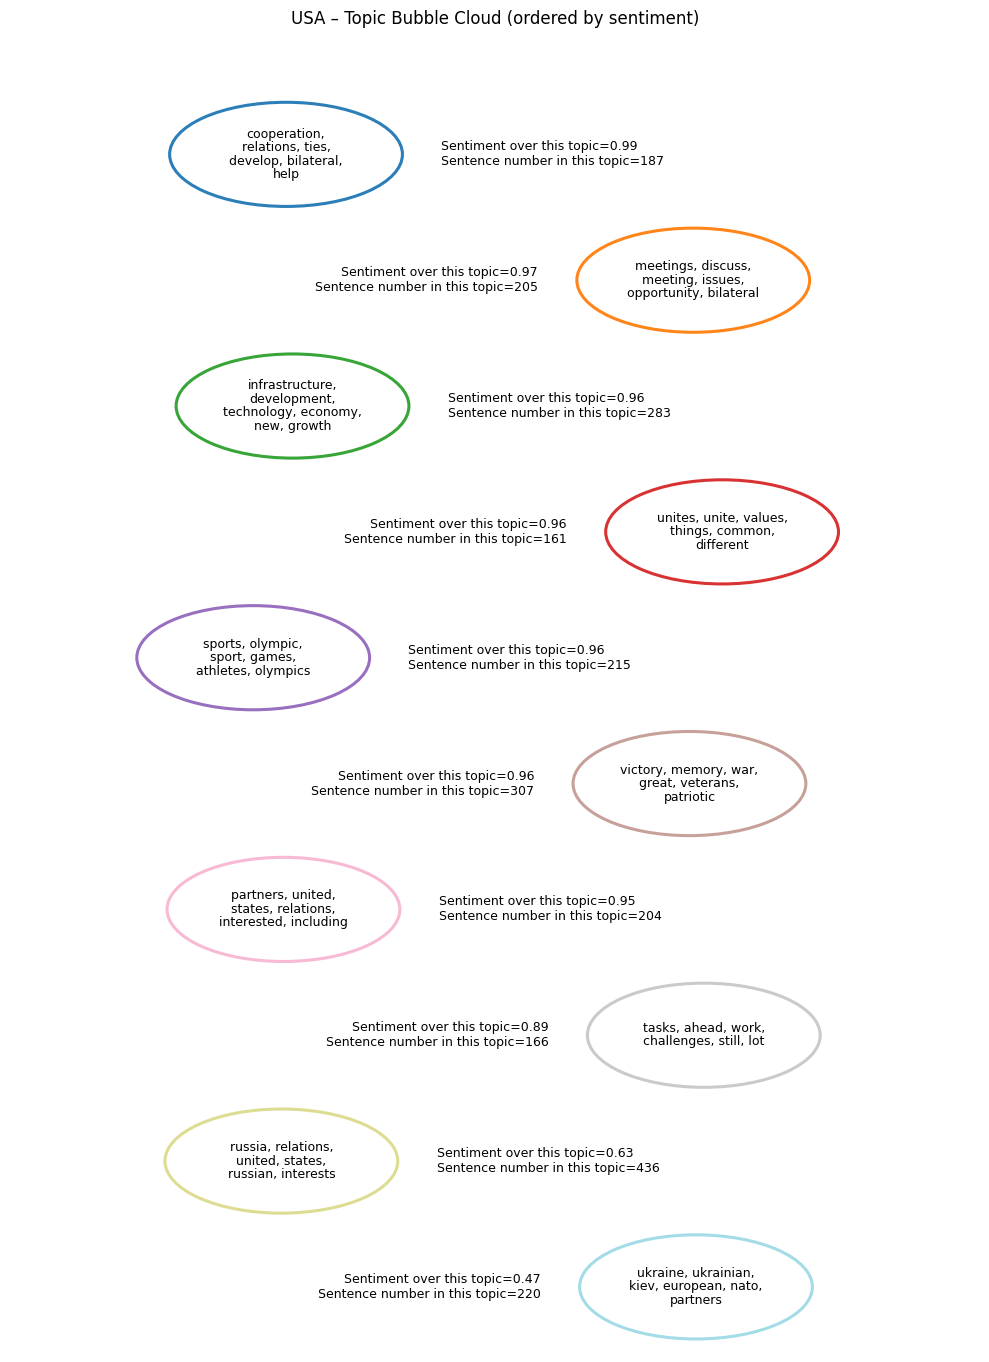

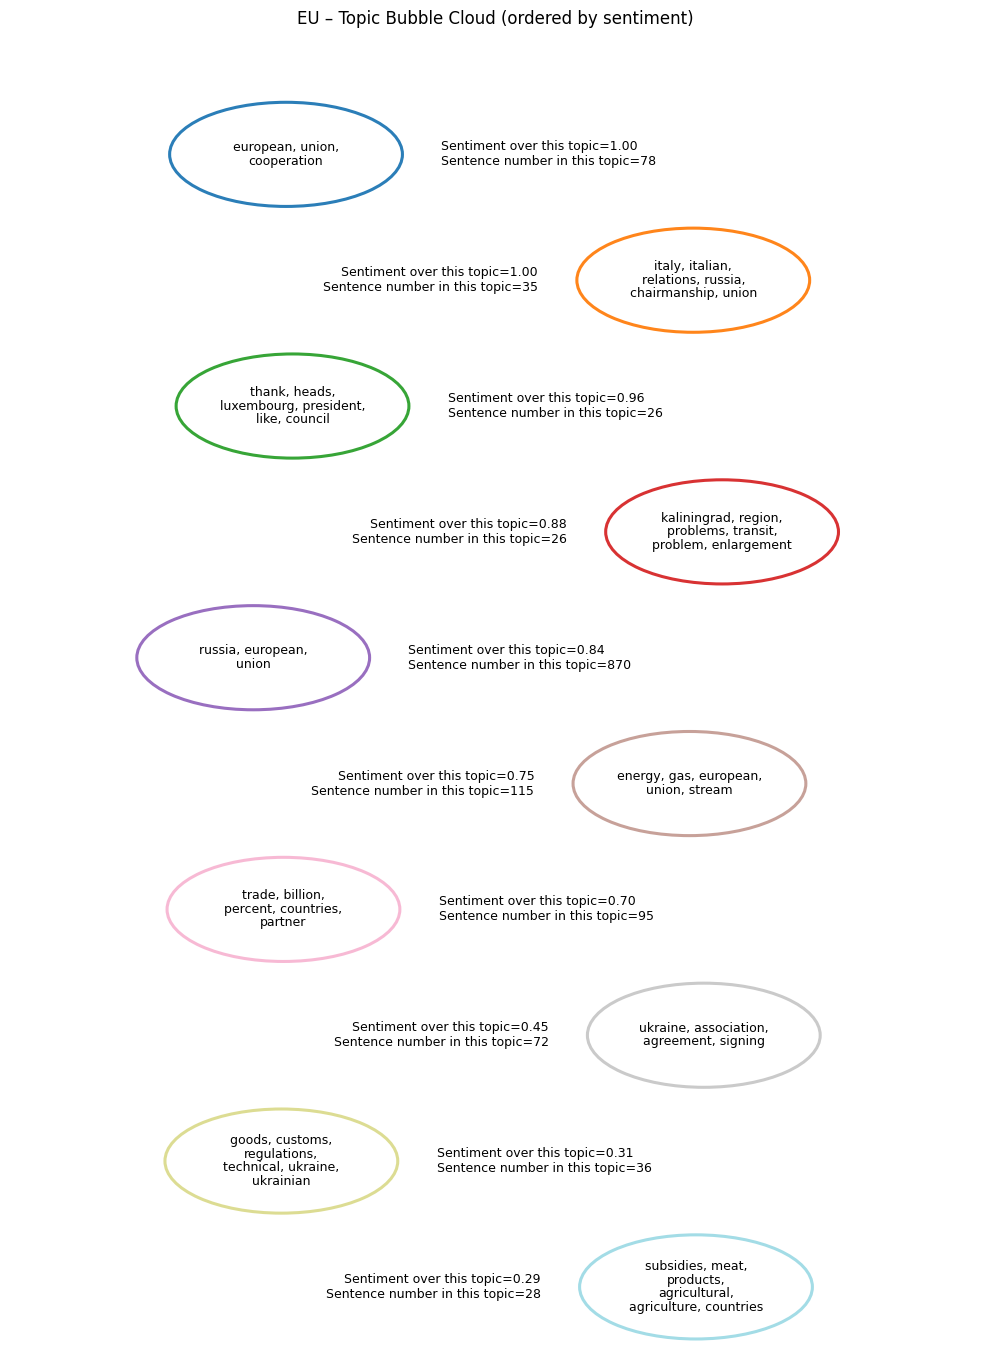

In [40]:
bubble_stack_cloud_equal(usa_summary, "USA – Topic Bubble Cloud (ordered by sentiment)")
bubble_stack_cloud_equal(eu_summary,  "EU – Topic Bubble Cloud (ordered by sentiment)")


In [41]:
eu_summary[eu_summary["keywords"].str.contains("kaliningrad", case=False, na=False)]


,topic,count,keywords,mean_pos_prob,positive_rate
8,8,26,"kaliningrad, region, problems, transit, proble...",0.883425,0.884615


In [46]:
topic_id = 8

kal_df = eu_sent[eu_sent["topic"] == topic_id].copy()
print(f"[INFO] {len(kal_df)} sentences in topic {topic_id}")
kal_df_sorted = kal_df.sort_values("pos_prob", ascending=False)



[INFO] 26 sentences in topic 8


In [49]:
import pandas as pd

kal_df_sorted["date_clean"] = pd.to_datetime(kal_df_sorted["date"], unit="ms")


In [52]:
for i, row in kal_df_sorted.iterrows():
    print("=" * 160)
    print(f"{i+1:02d}. Date: {row['date_clean'].date()} | P(pos) = {row['pos_prob']:.3f}")
    print(row["sentence"])



229. Date: 2002-11-11 | P(pos) = 0.999
The trustful character of our discussions has enabled us to consider all the possible consequences of the forthcoming enlargement of the EU, and of course the problem of the survival of the Kaliningrad Region was at the forefront.
49. Date: 2001-03-23 | P(pos) = 0.999
Given these conditions, the Kaliningrad Region, while remaining part of the Russian Federation and its domestic market, can become a testing ground for trying out new and effective forms of cooperation with foreign countries, the European Union included.
586. Date: 2004-12-23 | P(pos) = 0.999
Concerning our relations with the European Union on the Kaliningrad issue, on the main issue, that of passenger transit, we have worked out if not the final settlement then at least the main parameters with the EU and we are generally satisfied.
683. Date: 2005-07-03 | P(pos) = 0.999
Here, in Kaliningrad Region, we had a detailed discussion of development prospects for the region in the context 

### Change over time

1. How does the image of Ukraine (Poland, Germany, USA) change in his speeches from 
2000 to 2024? (Sentiment analysis + temporal aggregation, RoBERTa)


In [124]:
df_sent = df_sent[df_sent["sentence"] != ""].copy()


df_sent["date_dt"] = pd.to_datetime(df_sent["date"], unit="ms", errors="coerce")


df_sent = df_sent[df_sent["date_dt"].notna()].copy()


df_sent["year"] = df_sent["date_dt"].dt.year

df_sent = df_sent[(df_sent["year"] >= 1999) & (df_sent["year"] <= 2023)].reset_index(drop=True)

print("df_sent rows:", len(df_sent))
print(df_sent[["date", "date_dt", "year", "sentence"]].head())

df_sent rows: 389451
           date             date_dt  year  \
0  946598460000 1999-12-31 00:01:00  1999   
1  946598460000 1999-12-31 00:01:00  1999   
2  946598460000 1999-12-31 00:01:00  1999   
3  946598460000 1999-12-31 00:01:00  1999   
4  946598460000 1999-12-31 00:01:00  1999   

                                            sentence  
0  Dear friends, On New Year’s Eve, my family and...  
1                  But things took a different turn.  
2  On December 31, 1999, Russia’s first president...  
3  He has asked me to address the Russian people ...  
4  The powers of the head of state have been turn...  


In [103]:
ukraine_pattern = r"\b(?:Ukraine|Ukrainian)\b"
usa_pattern = r"\b(?:USA|U\.S\.A\.|U\.S\.|US|United States|America|American|Washington)\b"

ua_sent = df_sent[df_sent["sentence"].str.contains(ukraine_pattern, case=False, na=False, regex=True)].copy()
us_sent = df_sent[df_sent["sentence"].str.contains(usa_pattern, case=False, na=False, regex=True)].copy()

print("Ukraine sentences:", len(ua_sent))
print("USA sentences:", len(us_sent))




Ukraine sentences: 4417
USA sentences: 18193


In [104]:
ua_pos_probs, ua_labels = batched_sentiment(
    ua_sent["sentence"].tolist(),
    tokenizer,
    model,
    batch_size=32
)

us_pos_probs, us_labels = batched_sentiment(
    us_sent["sentence"].tolist(),
    tokenizer,
    model,
    batch_size=32
)

ua_sent["pos_prob"] = ua_pos_probs
ua_sent["label"] = ua_labels

us_sent["pos_prob"] = us_pos_probs
us_sent["label"] = us_labels



Sentiment:   0%|          | 0/139 [00:00<?, ?it/s]

Sentiment:   0%|          | 0/569 [00:00<?, ?it/s]

In [109]:
ua_yearly = (
    ua_sent
    .groupby("year")
    .agg(
        mean_pos_prob=("pos_prob", "mean"),
        n_sentences=("pos_prob", "size")
    )
    .reset_index()
)

us_yearly = (
    us_sent
    .groupby("year")
    .agg(
        mean_pos_prob=("pos_prob", "mean"),
        n_sentences=("pos_prob", "size")
    )
    .reset_index()
)

print("Ukraine yearly sentiment:")
print(ua_yearly)

print("\nUSA yearly sentiment:")
print(us_yearly)


Ukraine yearly sentiment:
    year  mean_pos_prob  n_sentences
0   2000       0.857573           36
1   2001       0.869868           87
2   2002       0.903651           54
3   2003       0.841690          133
4   2004       0.817052          242
5   2005       0.758103          163
6   2006       0.691014          159
7   2007       0.562985           73
8   2008       0.658211           71
9   2009       0.998717            1
10  2012       0.717164           75
11  2013       0.688733          283
12  2014       0.519779          901
13  2015       0.555297          365
14  2016       0.501746          157
15  2017       0.509956          167
16  2018       0.451003          200
17  2019       0.549069          198
18  2020       0.648021           71
19  2021       0.461324          186
20  2022       0.422064          612
21  2023       0.448718          183

USA yearly sentiment:
    year  mean_pos_prob  n_sentences
0   1999       0.998851            2
1   2000       0.755942   

In [110]:
MIN_N = 10

ua_yearly_filtered = ua_yearly[ua_yearly["n_sentences"] >= MIN_N].copy()
us_yearly_filtered = us_yearly[us_yearly["n_sentences"] >= MIN_N].copy()


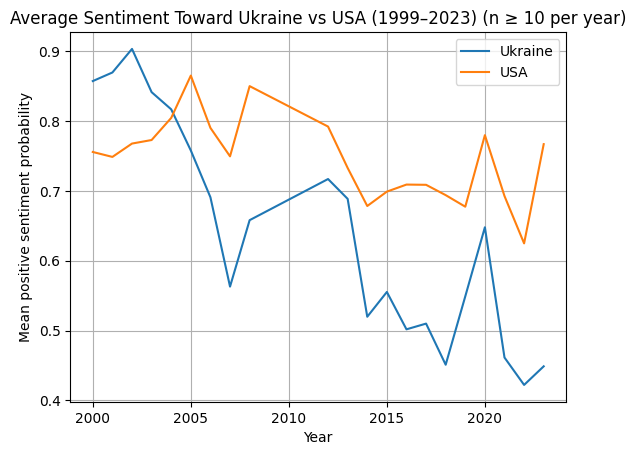

In [111]:
plt.figure()
plt.plot(ua_yearly_filtered["year"], ua_yearly_filtered["mean_pos_prob"], label="Ukraine")
plt.plot(us_yearly_filtered["year"], us_yearly_filtered["mean_pos_prob"], label="USA")

plt.title("Average Sentiment Toward Ukraine vs USA (1999–2023) (n ≥ 10 per year)")
plt.xlabel("Year")
plt.ylabel("Mean positive sentiment probability")
plt.legend()
plt.grid(True)
plt.show()


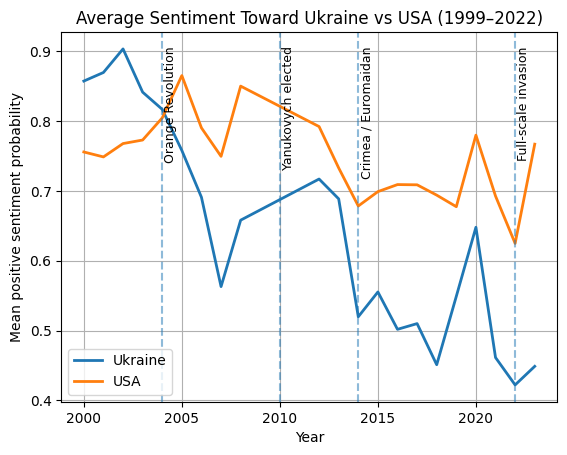

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(
    ua_yearly_filtered["year"],
    ua_yearly_filtered["mean_pos_prob"],
    label="Ukraine",
    linewidth=2
)

plt.plot(
    us_yearly_filtered["year"],
    us_yearly_filtered["mean_pos_prob"],
    label="USA",
    linewidth=2
)


events = {
    2004: "Orange Revolution",
    2010: "Yanukovych elected",
    2014: "Crimea / Euromaidan",
    2022: "Full-scale invasion"
}

for year, label in events.items():
    plt.axvline(year, linestyle="--", alpha=0.5)
    plt.text(
        year + 0.1,
        plt.ylim()[1] - 0.02,
        label,
        rotation=90,
        verticalalignment="top",
        fontsize=9
    )

plt.title("Average Sentiment Toward Ukraine vs USA (1999–2022)")
plt.xlabel("Year")
plt.ylabel("Mean positive sentiment probability")
plt.legend()
plt.grid(True)
plt.show()


### Interpretation

### 6. How does he portray Russia’s role in the world – as a defensive or expansionist power? (Sentiment analysis + topic context, RoBERTa / BERTopic)

In [113]:

df_sent = df_sent[df_sent["sentence"] != ""].copy()


df_sent["date_dt"] = pd.to_datetime(df_sent["date"], unit="ms", errors="coerce")


df_sent = df_sent[df_sent["date_dt"].notna()].copy()


df_sent["year"] = df_sent["date_dt"].dt.year

df_sent = df_sent[(df_sent["year"] >= 1999) & (df_sent["year"] <= 2023)].reset_index(drop=True)

print("df_sent rows:", len(df_sent))
print(df_sent[["date", "date_dt", "year", "sentence"]].head())


df_sent rows: 389451
           date             date_dt  year  \
0  946598460000 1999-12-31 00:01:00  1999   
1  946598460000 1999-12-31 00:01:00  1999   
2  946598460000 1999-12-31 00:01:00  1999   
3  946598460000 1999-12-31 00:01:00  1999   
4  946598460000 1999-12-31 00:01:00  1999   

                                            sentence  
0  Dear friends, On New Year’s Eve, my family and...  
1                  But things took a different turn.  
2  On December 31, 1999, Russia’s first president...  
3  He has asked me to address the Russian people ...  
4  The powers of the head of state have been turn...  


In [114]:
import re
import pandas as pd

DEFENSIVE_TERMS = [
    r"threat", r"threaten", r"security", r"secure",
    r"aggression", r"aggressive", r"attack", r"assault",
    r"encircle", r"encirclement",
    r"pressure", r"blackmail", r"provocation", r"provocative",
    r"sanction", r"blockade",
    r"defen[cs]e", r"defend", r"protect", r"protection",
    r"necessity", r"forced", r"compelled",
    r"nato", r"alliance", r"military build[- ]?up", r"escalat"
]

EXPANSIONIST_TERMS = [
    r"influence", r"interests?", r"sphere of influence",
    r"strategic", r"presence", r"projection of power", r"power projection",
    r"expan(d|sion|ding)", r"extend", r"reach",
    r"historical responsibility", r"historic(al)? mission",
    r"protect(ing)? russians abroad", r"compatriots abroad",
    r"russian world", r"russkiy mir",  
    r"territor(ial|y)", r"annex", r"incorporat", r"reunif",
    r"buffer zone", r"security belt"
]


def compile_pattern(terms):
   
    terms = [t.replace(" ", r"\s+") for t in terms]
    return re.compile(r"(" + "|".join(terms) + r")", flags=re.IGNORECASE)

pat_def = compile_pattern(DEFENSIVE_TERMS)
pat_exp = compile_pattern(EXPANSIONIST_TERMS)


base = df_sent.copy()
base["sentence"] = base["sentence"].fillna("").astype(str)

base["is_defensive"] = base["sentence"].str.contains(pat_def, na=False)
base["is_expansionist"] = base["sentence"].str.contains(pat_exp, na=False)


base["defensive_hits"] = base["sentence"].str.findall(pat_def).str.len()
base["expansionist_hits"] = base["sentence"].str.findall(pat_exp).str.len()


df_defensive = base[base["is_defensive"] & ~base["is_expansionist"]].copy()
df_expansionist = base[base["is_expansionist"] & ~base["is_defensive"]].copy()
df_both = base[base["is_defensive"] & base["is_expansionist"]].copy()
df_neither = base[~base["is_defensive"] & ~base["is_expansionist"]].copy()

print("[COUNTS]")
print("Defensive only    :", len(df_defensive))
print("Expansionist only :", len(df_expansionist))
print("Both (mixed)      :", len(df_both))
print("Neither           :", len(df_neither))




[COUNTS]
Defensive only    : 17737
Expansionist only : 20767
Both (mixed)      : 2635
Neither           : 348312


In [129]:
print("\n[DEFENSIVE EXAMPLES – last 20]")
print(df_defensive[["sentence", "date_dt", "defensive_hits", "expansionist_hits"]].tail(20).to_string(index=False))

print("\n[EXPANSIONIST EXAMPLES – last 20]")
print(df_expansionist[["sentence", "date_dt", "defensive_hits", "expansionist_hits"]].tail(20).to_string(index=False))


[DEFENSIVE EXAMPLES – last 20]
                                                                                                                                                                                                                                                                                                                  sentence             date_dt  defensive_hits  expansionist_hits
                                                                                                                                                                                                 Greater attention is needed to protect the state borders, especially the areas in close proximity to the line of contact. 2023-12-20 00:00:00               1                  0
                                                                                                                                                                                                                                    

AMBIGUOUS METHOD :

"To begin with, when the Bashkirs voluntarily joined the Russian Empire, 
they volunteered to take on a special mission to defend the outer frontier of our Fatherland and to secure its borders."

date : 2023-01-13 14:35:00

That sounds like an Expansionist statement ? But it is classified as defensive..

This statement is not related to what we want to study :

"They need to hire workers, they need to maintain or expand production capacity, do you understand that?"


It is classified as defensive

In [133]:
df.columns

Index(['date', 'persons', 'transcript_unfiltered', 'kremlin_id', 'place',
       'title', 'teaser', 'tags', 'transcript_filtered', 'wordlist', 'year',
       'month', 'text_raw', 'sentences', 'sentence_count', 'tokens_full',
       'tokens_clean', 'tokens_lexical', 'tokens_nostop', 'tokens_lemma',
       'token_count', 'unique_tokens', 'lexical_diversity',
       'avg_sentence_length', 'exclamation_count', 'question_count',
       'ellipsis_count'],
      dtype='object')

In [135]:
df["sentences"][0]

['Dear friends, On New Year’s Eve, my family and I planned to gather round the TV, just as you probably did, to listen to the address by President Boris Yeltsin.',
 'But things took a different turn.',
 'On December 31, 1999, Russia’s first president decided to resign.',
 'He has asked me to address the Russian people today.',
 'The powers of the head of state have been turned over to me today.',
 'The presidential election will be held in three months.',
 'I assure you that there will be no vacuum of power, not for a minute.',
 'I promise you that any attempts to act contrary to the Russian law and constitution will be cut short.',
 'The state will stand firm to protect the freedom of speech, the freedom of conscience, the freedom of the mass media, ownership rights, these fundamental elements of a civilised society.',
 'The Armed Forces, the Federal Frontier Service, and law-enforcement agencies are working in the usual regime.',
 'The state continues to uphold the safety of every Ru